- 16 aziende (sorgenti), 19 files totali (4 relativi alla stessa azienda ariregister)
- 21 MB di spazio, ~1MB a sorgente


In [1]:
import pandas as pd
import os 
import json
import seaborn as sns
import matplotlib.pyplot as plt

SRC = 'sources/'

In [2]:
schemas = []
for filename in os.listdir(SRC):
    file_path = os.path.join(SRC, filename)
    if file_path.endswith('.csv'):
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
    elif file_path.endswith('.json'):
        with open(file_path, 'r') as f:
            data = json.load(f)
        if isinstance(data, list):
            df = pd.json_normalize(data)
        else:
            df = pd.json_normalize([data])
    elif file_path.endswith('.xls'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.jsonl'):
        df = pd.read_json(file_path, lines=True)
    else: 
        print(f"Unsupported file type: {file_path}")
        continue    

    schema = {col: str(dtype) for col, dtype in zip(df.columns, df.dtypes)}
    schemas.append({"file": filename, "schema": schema})

In [3]:
all_columns = set()
for schema in schemas:
    all_columns.update(schema["schema"].keys())

comparison = []
for col in all_columns:
    col_info = {"Column": col}
    for schema in schemas:
        col_info[schema["file"]] = schema["schema"].get(col, pd.NA)
    comparison.append(col_info)

schema_comparison = pd.DataFrame(comparison)
display(schema_comparison)

,Column,AmbitionBox.csv,campaignindia.csv,companiesMarketCap_dataset.jsonl,company_social_urls.csv,DDD-cbinsight.com.csv,DDD-teamblind.com.csv,disfold.com.json,ft.com.json,hitHorizons_dataset.jsonl,MalPatSaj-forbes.com.xls,MalPatSaj-wikipedia.org.xls,output_globaldata.json,output_govuk_bigsize.json,valueToday_dataset.jsonl,wissel-activity-ariregister.rik.ee.csv,wissel-aziende-ariregister.rik.ee.csv,wissel-aziende-info-clipper.com.csv,wissel-partners-ariregister.rik.ee.csv,wissel-rappresentanti-ariregister.rik.ee.csv
0,world_rank,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>
1,founded,<NA>,<NA>,<NA>,<NA>,float64,float64,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,founders,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>
3,total_assets_in_usd,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>
4,investors,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Contribution,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>
99,INDEX,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,int64,<NA>,<NA>
100,name,<NA>,<NA>,object,<NA>,object,object,object,object,object,<NA>,<NA>,object,object,object,<NA>,<NA>,<NA>,<NA>,<NA>
101,annual_net_income_in_usd,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,object,<NA>,<NA>,<NA>,<NA>,<NA>


In [4]:
# Save the comparison to a CSV file
output = "schema_comparison.csv"
schema_comparison['Column'] = schema_comparison['Column'].str.lower()  
schema_comparison = schema_comparison.sort_values(by="Column", ascending=True)
schema_comparison.columns = schema_comparison.columns.str.strip()
schema_comparison['Column'] = schema_comparison['Column'].str.strip()
schema_comparison.to_csv(output, index=False)

### Some stats

In [5]:
# Extract some stats

# Sort and display the most common attributes
attribute_coverage = schema_comparison.set_index('Column').notna().sum(axis=1)
attribute_coverage = attribute_coverage.sort_values(ascending=False)
print(attribute_coverage)


Column
name                9
name                7
industry            5
unnamed: 0          5
code                3
                   ..
facebook            1
est_of_ownership    1
emtak code          1
deletion date       1
world_rank          1
Length: 103, dtype: int64


In [6]:
# Count available attributes per data source
source_completeness = schema_comparison.set_index('Column').notna().sum(axis=0)
print("Attributes per source:\n", source_completeness.sort_values(ascending=False))

Attributes per source:
 valueToday_dataset.jsonl                        18
DDD-cbinsight.com.csv                           11
wissel-aziende-info-clipper.com.csv             11
wissel-aziende-ariregister.rik.ee.csv           10
companiesMarketCap_dataset.jsonl                 9
hitHorizons_dataset.jsonl                        9
output_globaldata.json                           9
MalPatSaj-forbes.com.xls                         7
DDD-teamblind.com.csv                            7
ft.com.json                                      7
MalPatSaj-wikipedia.org.xls                      7
output_govuk_bigsize.json                        7
disfold.com.json                                 6
wissel-partners-ariregister.rik.ee.csv           5
AmbitionBox.csv                                  5
wissel-activity-ariregister.rik.ee.csv           5
campaignindia.csv                                5
company_social_urls.csv                          5
wissel-rappresentanti-ariregister.rik.ee.csv     5
dtype: 

In [7]:
# Check attributes present in all sources
common_attributes = schema_comparison.set_index('Column').notna().all(axis=1)

# Properly filter rows using the correct index
common_attributes_list = schema_comparison.loc[common_attributes[common_attributes].index, 'Column'].tolist()
print("Attributes in all sources:\n", common_attributes_list)

Attributes in all sources:
 []


In [8]:
# Count occurrences of each type
type_counts = schema_comparison.set_index('Column').apply(pd.Series.value_counts).fillna(0)
print("Data type counts across sources:\n", type_counts)

Data type counts across sources:
          AmbitionBox.csv  campaignindia.csv  companiesMarketCap_dataset.jsonl  \
float64              0.0                0.0                               0.0   
int64                0.0                1.0                               1.0   
object               5.0                4.0                               8.0   

         company_social_urls.csv  DDD-cbinsight.com.csv  \
float64                      0.0                      1   
int64                        0.0                      1   
object                       5.0                      9   

         DDD-teamblind.com.csv  disfold.com.json  ft.com.json  \
float64                      1               0.0          0.0   
int64                        1               0.0          0.0   
object                       5               6.0          7.0   

         hitHorizons_dataset.jsonl  MalPatSaj-forbes.com.xls  \
float64                        0.0                       0.0   
int64          

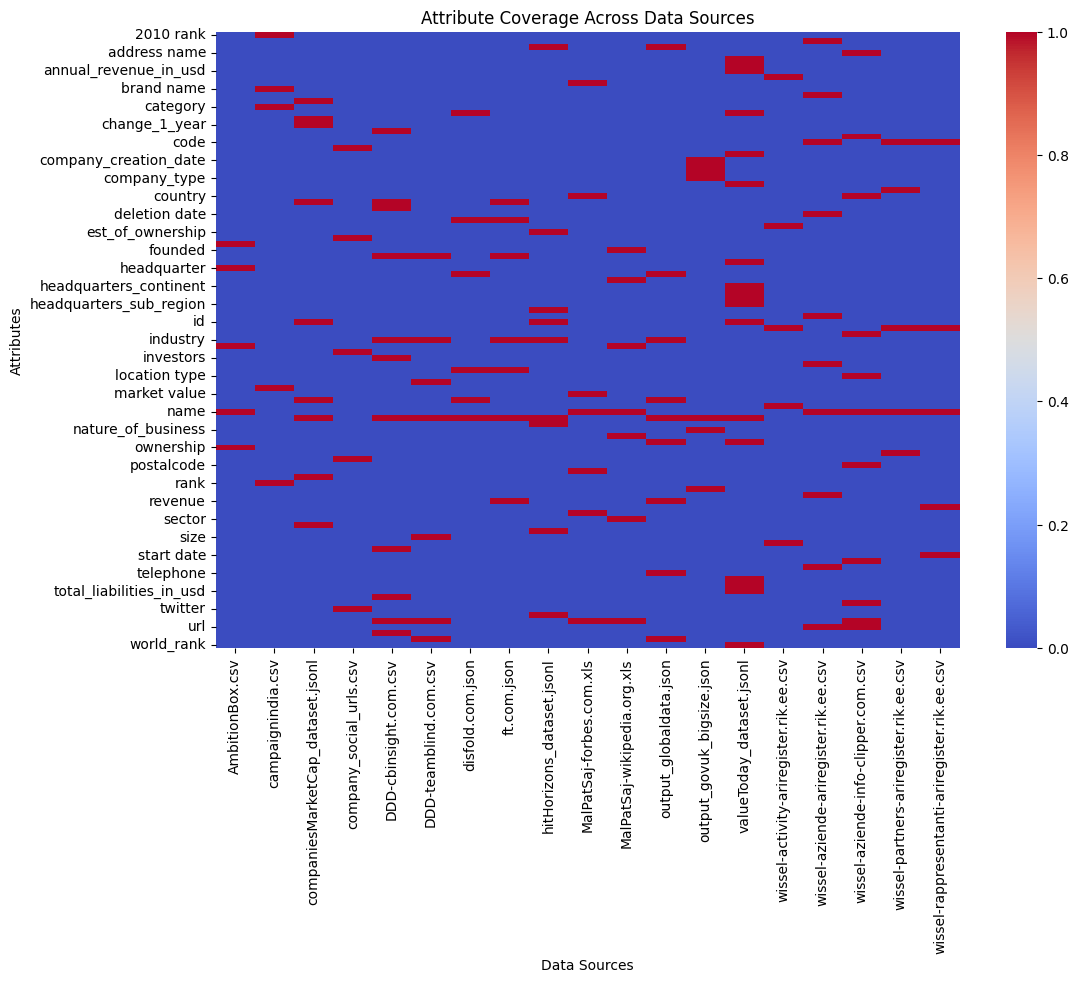

In [9]:
# Convert to binary presence/absence for heatmap visualization
binary_df = schema_comparison.set_index('Column').notna().astype(int)

plt.figure(figsize=(12, 8))
sns.heatmap(binary_df, cmap='coolwarm', cbar=True)
plt.title('Attribute Coverage Across Data Sources')
plt.xlabel('Data Sources')
plt.ylabel('Attributes')
plt.show()

In [10]:
row_counts = []
for schema in schemas:
    filename = schema['file']
    file_path = os.path.join(SRC, filename)
    if file_path.endswith('.csv'):
        try:
            df = pd.read_csv(file_path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding='ISO-8859-1')
    elif file_path.endswith('.json'):
        with open(file_path, 'r') as f:
            data = json.load(f)
        if isinstance(data, list):
            df = pd.json_normalize(data)
        else:
            df = pd.json_normalize([data])
    elif file_path.endswith('.xls'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.jsonl'):
        df = pd.read_json(file_path, lines=True)
    else:
        print(f"Unsupported file type: {file_path}")
        continue
    
    row_counts.append({"file": filename, "row_count": len(df)})

row_counts_df = pd.DataFrame(row_counts)
display(row_counts_df)
print(row_counts_df['row_count'].sum())	

,file,row_count
0,AmbitionBox.csv,9899
1,campaignindia.csv,1000
2,companiesMarketCap_dataset.jsonl,5897
3,company_social_urls.csv,848
4,DDD-cbinsight.com.csv,1185
5,DDD-teamblind.com.csv,946
6,disfold.com.json,16097
7,ft.com.json,5000
8,hitHorizons_dataset.jsonl,667
9,MalPatSaj-forbes.com.xls,2000


79004


### Analisi schema mediato popolato

C:\Users\emigi\AppData\Local\Temp\ipykernel_8128\1537432602.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attribute_coverage.index, y=attribute_coverage.values, palette="viridis")


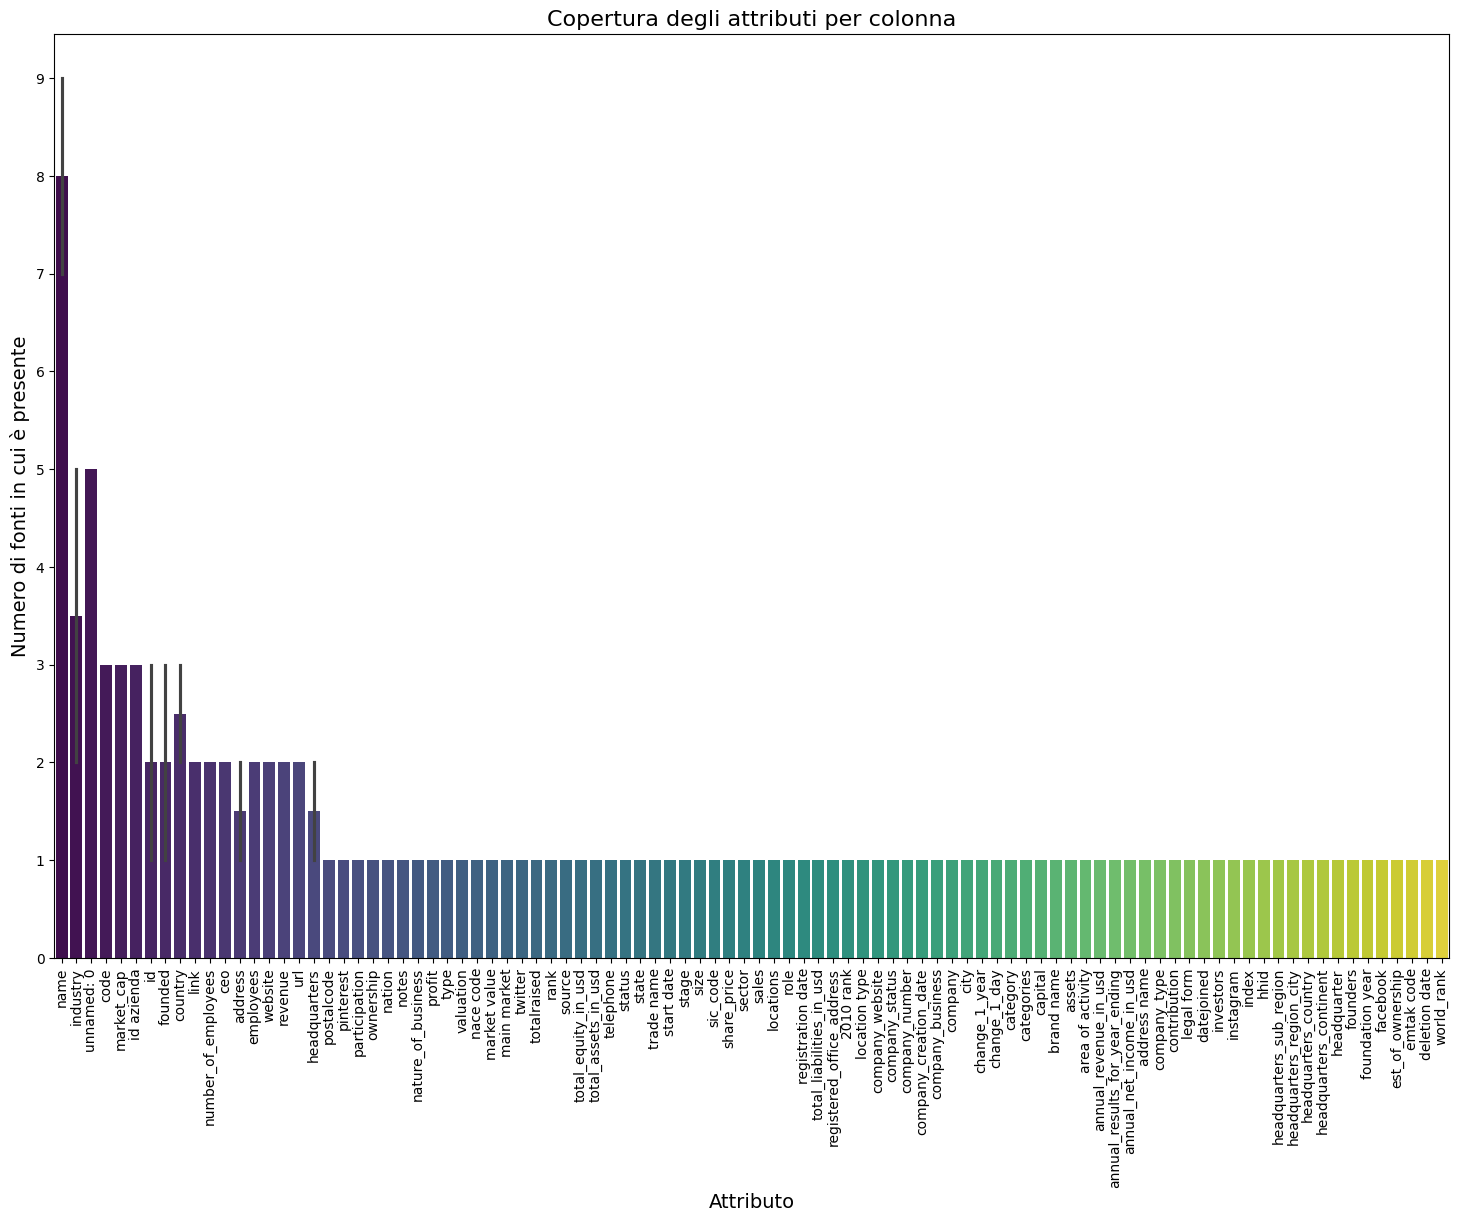

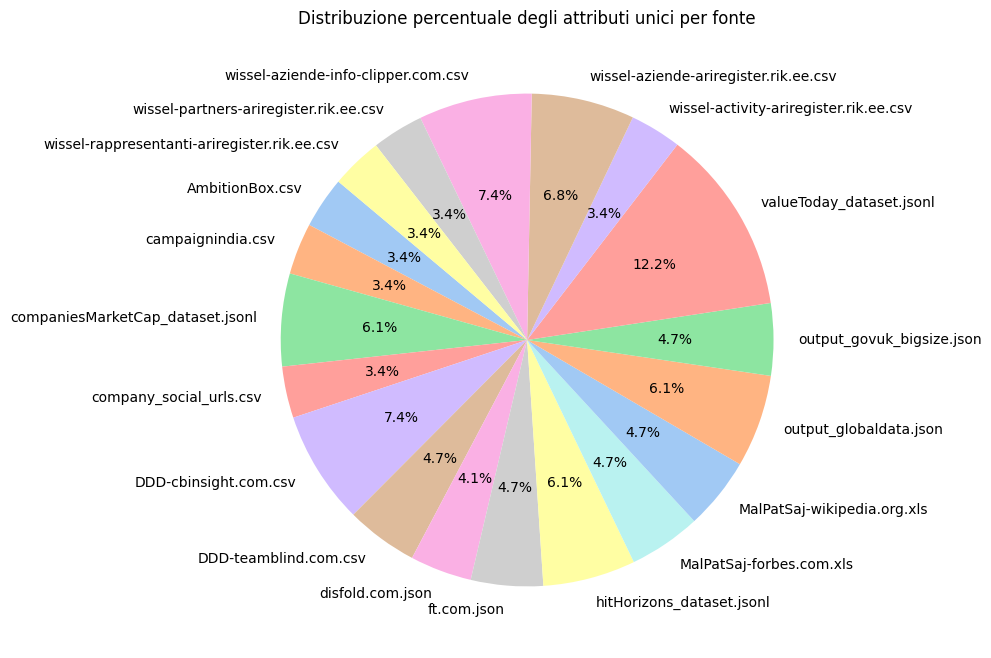

C:\Users\emigi\AppData\Local\Temp\ipykernel_8128\1537432602.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=row_counts_df["file"], y=row_counts_df["row_count"], palette="coolwarm")


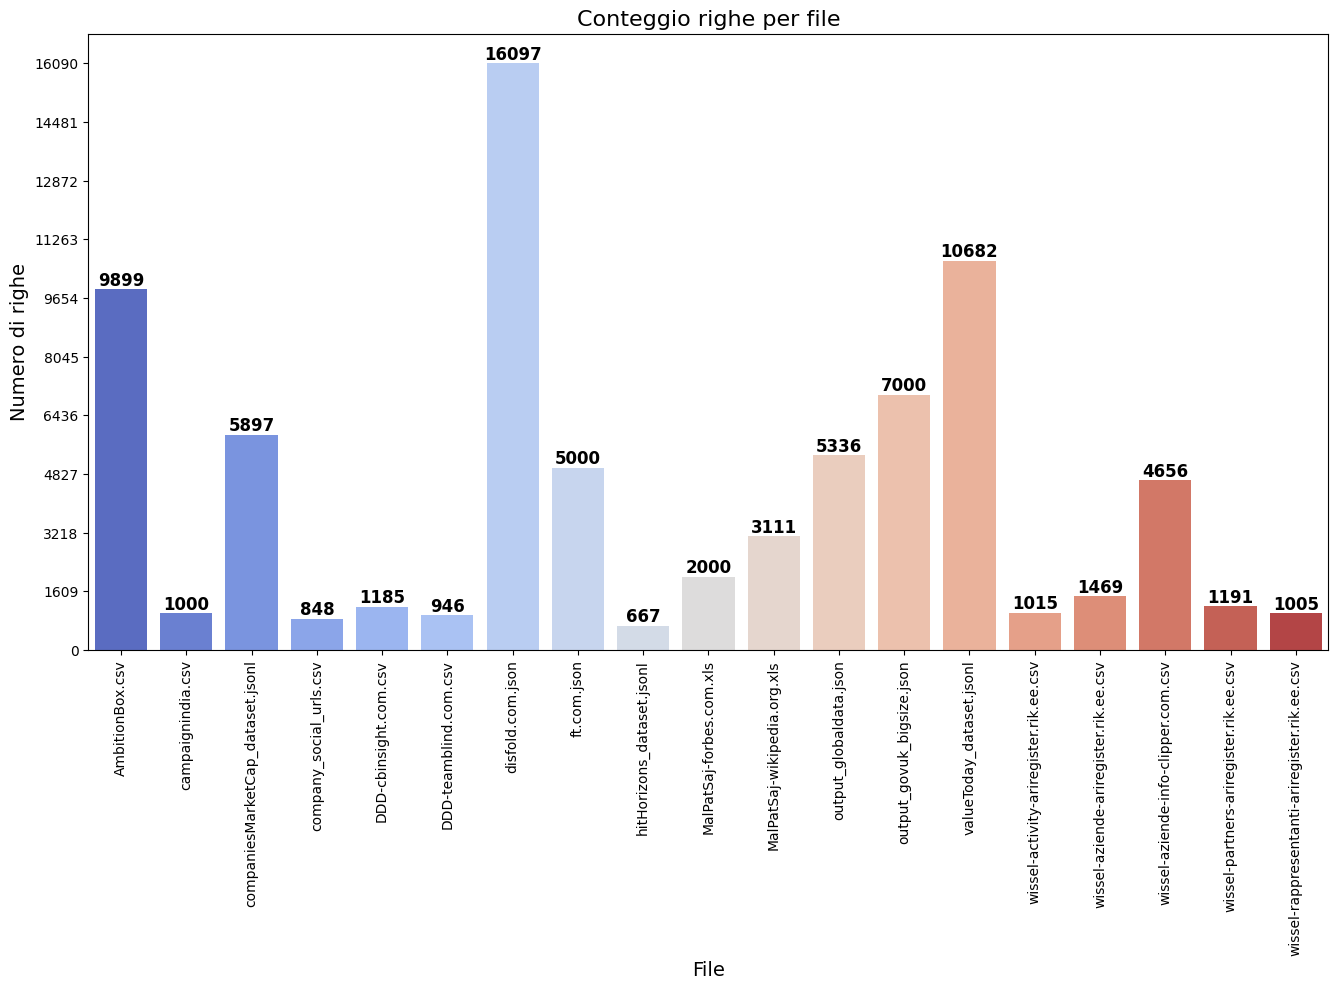

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Bar chart: Coverage degli attributi nelle diverse fonti di dati (grafico più grande con ticks personalizzati)
plt.figure(figsize=(18, 12))  # Aumenta la dimensione della figura
sns.barplot(x=attribute_coverage.index, y=attribute_coverage.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Copertura degli attributi per colonna", fontsize=16)
plt.xlabel("Attributo", fontsize=14)
plt.ylabel("Numero di fonti in cui è presente", fontsize=14)

# Imposta i valori sull'asse y (da 0 al massimo valore di y, con step di 1)
plt.yticks(range(int(attribute_coverage.values.max()) + 1))

plt.show()


# Conta quanti attributi unici ci sono in totale
total_unique_attributes = schema_comparison['Column'].nunique()

# Conta la copertura degli attributi per ogni fonte
normalized_source_completeness = source_completeness / total_unique_attributes * 100

# Pie chart con attribuzione pesata
plt.figure(figsize=(8, 8))
plt.pie(normalized_source_completeness, labels=normalized_source_completeness.index, autopct='%1.1f%%', 
        startangle=140, colors=sns.color_palette("pastel"))
plt.title("Distribuzione percentuale degli attributi unici per fonte")
plt.show()


# Bar chart: Conteggio delle righe nei file elaborati con più dettaglio
plt.figure(figsize=(16, 8))  # Grafico più grande per miglior visibilità
ax = sns.barplot(x=row_counts_df["file"], y=row_counts_df["row_count"], palette="coolwarm")

plt.xticks(rotation=90)
plt.title("Conteggio righe per file", fontsize=16)
plt.xlabel("File", fontsize=14)
plt.ylabel("Numero di righe", fontsize=14)

# Imposta i tick sull'asse Y con step regolare
y_max = row_counts_df["row_count"].max()
plt.yticks(range(0, y_max + 1, max(1, y_max // 10)))  # Suddivide in 10 intervalli

# Aggiunge i valori esatti sopra ogni barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),  
                ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

plt.show()



In [12]:
import pandas as pd

# Carica il file CSV
aziende_df = pd.read_csv("aziende.csv", encoding="utf-8")

# Trova le righe duplicate
aziende_duplicati_righe = aziende_df[aziende_df.duplicated()]

# Mostra le righe duplicate
print("Esempio di righe duplicate nel file 'aziende.csv':")
print(aziende_duplicati_righe.head())  # Mostra le prime righe duplicate (se ce ne sono)


C:\Users\emigi\AppData\Local\Temp\ipykernel_8128\1027090770.py:4: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  aziende_df = pd.read_csv("aziende.csv", encoding="utf-8")


Esempio di righe duplicate nel file 'aziende.csv':
    company_id                      company_name trade_name  industry sector  \
5     02921121  'q' accountancy services limited        NaN       NaN    NaN   
195   12816840              5d uk operations ltd        NaN       NaN    NaN   
197   12816020             5d uk real estate ltd        NaN       NaN    NaN   
211        NaN                   6d technologies        NaN   telecom    NaN   
253        NaN                           99acres        NaN  internet    NaN   

    categories company_status             company_type  \
5          NaN         active  private limited company   
195        NaN         active  private limited company   
197        NaN         active  private limited company   
211        NaN            NaN                      NaN   
253        NaN            NaN                   public   

                              headquarters  \
5                                      NaN   
195                        

C:\Users\emigi\AppData\Local\Temp\ipykernel_8128\3939832820.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=source_completeness_sorted.index, y=source_completeness_sorted.values, palette="Blues_d")


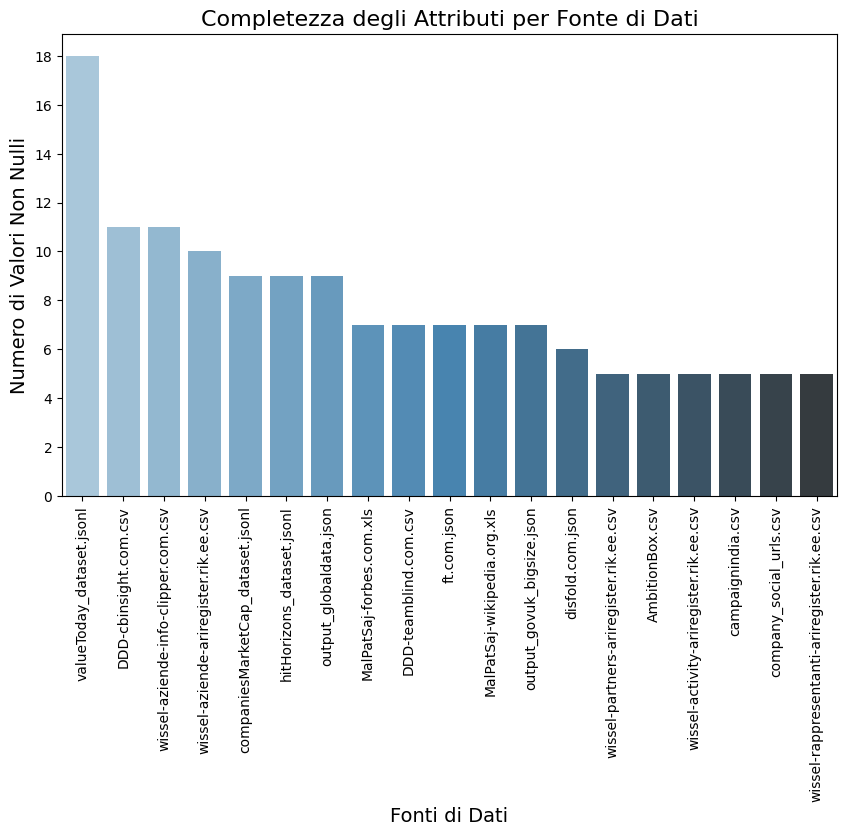

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Supponiamo che `schema_comparison` sia il DataFrame contenente i tuoi dati
# Calcola la completezza per fonte di dati
source_completeness = schema_comparison.set_index('Column').notna().sum(axis=0)

# Ordina i risultati in ordine decrescente
source_completeness_sorted = source_completeness.sort_values(ascending=False)

# Creazione del grafico
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=source_completeness_sorted.index, y=source_completeness_sorted.values, palette="Blues_d")

# Dettagli del grafico
ax.set_title('Completezza degli Attributi per Fonte di Dati', fontsize=16)
ax.set_xlabel('Fonti di Dati', fontsize=14)
ax.set_ylabel('Numero di Valori Non Nulli', fontsize=14)
plt.xticks(rotation=90)  # Ruotare le etichette sull'asse X per una visibilità migliore

# Impostazione dell'asse Y per mostrare numeri interi fino a 18
ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='upper'))  # Limita la scala dell'asse Y a numeri interi

plt.show()


In [14]:
import pandas as pd
import os
import json

SRC = "sources/"

# Lista per salvare le statistiche
stats = []

# Scandisce i file nella cartella
for filename in os.listdir(SRC):
    file_path = os.path.join(SRC, filename)
    
    # Caricamento dei file
    if file_path.endswith(".csv"):
        try:
            df = pd.read_csv(file_path, encoding="utf-8")
        except UnicodeDecodeError:
            df = pd.read_csv(file_path, encoding="ISO-8859-1")
    elif file_path.endswith(".json"):
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        df = pd.json_normalize(data) if isinstance(data, list) else pd.json_normalize([data])
    elif file_path.endswith(".xls") or file_path.endswith(".xlsx"):
        df = pd.read_excel(file_path)
    elif file_path.endswith(".jsonl"):
        df = pd.read_json(file_path, lines=True)
    else:
        print(f"Tipo di file non supportato: {file_path}")
        continue

    # Conta i valori non nulli per ogni colonna
    non_null_counts = df.notna().sum()

    # Aggiunge le statistiche alla lista
    for col, count in non_null_counts.items():
        stats.append({"File": filename, "Attributo": col, "Valori Non Nulli": count})

# Converte le statistiche in un DataFrame
stats_df = pd.DataFrame(stats)

# Calcola statistiche generali
num_files = stats_df["File"].nunique()
num_attributes = stats_df["Attributo"].nunique()
avg_attributes_per_file = stats_df.groupby("File")["Attributo"].nunique().mean()
avg_attribute_usage = stats_df.groupby("Attributo")["File"].nunique().mean()

# Stampa i risultati
print(f"\nAnalisi della distribuzione degli attributi:")
print(f"Numero di file analizzati: {num_files}")
print(f"Numero totale di attributi: {num_attributes}")
print(f"Attributi medi per file: {avg_attributes_per_file:.2f}")
print(f"Utilizzo medio degli attributi nei file: {avg_attribute_usage:.2f}")

# Determina se la distribuzione è sparsa
sparse_threshold = 0.2  # 20% dei file devono contenere l'attributo
sparse_attributes = stats_df.groupby("Attributo")["File"].nunique() / num_files < sparse_threshold
num_sparse_attributes = sparse_attributes.sum()
print(f"Numero di attributi usati in meno del {sparse_threshold * 100}% dei file: {num_sparse_attributes}")

# Salva i risultati in un file CSV
output_file = "attributi_distribuzione.csv"
stats_df.to_csv(output_file, index=False)
print(f"\nStatistiche salvate in: {output_file}")



Analisi della distribuzione degli attributi:
Numero di file analizzati: 19
Numero totale di attributi: 103
Attributi medi per file: 7.79
Utilizzo medio degli attributi nei file: 1.44
Numero di attributi usati in meno del 20.0% dei file: 99

Statistiche salvate in: attributi_distribuzione.csv
